## 기말고사 연습문제 1

### 패키지 선언

100%|██████████| 170M/170M [00:11<00:00, 14.5MB/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
50000
torch.Size([3, 32, 32])
9


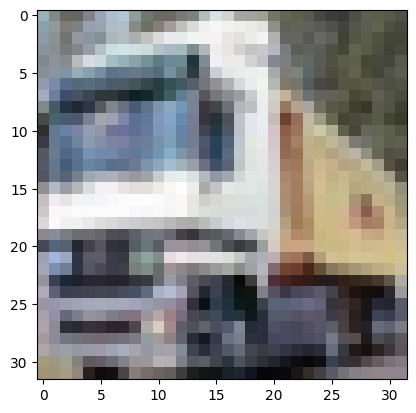

In [39]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torchsummary import summary


# Training dataset 다운로드
cifar10_train = dataset.CIFAR10(root = "./", # 데이터셋을 저장할 위치
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar10_test = dataset.CIFAR10(root = "./",
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

from matplotlib import pyplot as plt
print(len(cifar10_train))     # training dataset 개수 확인

first_data = cifar10_train[1]
print(first_data[0].shape)  # 두번째 data의 형상 확인
print(first_data[1])        # 두번째 data의 정답 확인


plt.imshow(first_data[0].permute(1, 2, 0))
plt.show()

### CNN 모델 구현

In [36]:
class TestModel (nn.Module):
  def __init__ (self):
    super(TestModel, self).__init__()
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.conv1_2 = nn.Conv2d(in_channels=16,out_channels = 32 ,kernel_size=3,padding=1)
    self.skip1 = nn.Conv2d(in_channels=3,out_channels = 32 ,kernel_size=3,padding=1)

    self.conv2_1 = nn.Conv2d(in_channels=35, out_channels=32, kernel_size=3, padding=1)
    self.conv2_2 = nn.Conv2d(in_channels=32,out_channels = 64 ,kernel_size=3,padding=1)
    self.skip2 = nn.Conv2d(in_channels=35,out_channels = 64 ,kernel_size=3,padding=1)
    self.adaptivePool = nn.AdaptiveAvgPool2d((1, 1))
    self.conv_ch1 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1)
    self.conv_ch2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1)


    self.conv3_1 = nn.Conv2d(in_channels=99, out_channels=128, kernel_size=3, padding=1)
    self.conv3_2 = nn.Conv2d(in_channels=128,out_channels =256 ,kernel_size=3,padding=1)
    self.skip3 = nn.Conv2d(in_channels=99,out_channels = 256 ,kernel_size=3,padding=1)

    self.fc1 = nn.Linear(in_features=4096,out_features=512)
    self.fc2 = nn.Linear(in_features=512,out_features=256)
    self.fc3 = nn.Linear(in_features=256,out_features=10)

    self.maxpolling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()


  def forward(self, x):
    # convolution layers
    in_feature = x
    out1 = self.relu(self.conv1_1(x))
    out1 = self.relu(self.conv1_2(out1))
    skip1 = self.relu(self.skip1(in_feature))
    out1 = out1+skip1
    out1 = torch.cat([out1,in_feature],dim=1)
    out1 = self.maxpolling(out1)


    in_feature = out1
    out2 = self.relu(self.conv2_1(out1))
    out2 = self.relu(self.conv2_2(out2))
    ca_out = self.adaptivePool(out2)
    ca_out = self.conv_ch2(self.relu(self.conv_ch1(ca_out)))
    out2 = out2*ca_out
    skip2 = self.relu(self.skip2(in_feature))
    out2=out2+skip2
    out2 = torch.cat([out2,in_feature],dim=1)
    out2 = self.maxpolling(out2)

    in_feature = out2
    out3 = self.relu(self.conv3_1(out2))
    out3 = self.relu(self.conv3_2(out3))
    skip3 = self.relu(self.skip3(in_feature))
    out3 = out3+skip3
    out3 = self.maxpolling(out3)

    out = out3.reshape(-1, 4096)

    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)

    # fully connected layers


    return out

## 모델 파라미터 개수 확인

In [40]:
summary(TestModel(), (3, 32,32), batch_size=-1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             896
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 35, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]          10,112
              ReLU-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Conv2d-13             [-1, 64, 1, 1]           4,160
             ReLU-14             [-1, 6

### Hyper-parameters 지정 / Training / Test

In [41]:
# Hyper parameter
batch_size = 100
learning_rate = 0.1
training_epochs = 20
loss_function = nn.CrossEntropyLoss()
network = TestModel()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)
data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

# Training
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

network = network.to(device)
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:

    img = img.to(device)
    label = label.to(device)

    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

#Test
network = network.to('cpu')
with torch.no_grad(): # test에서는 기울기 계산 제외

  img_test = torch.tensor(np.transpose(cifar10_test.data, (0, 3, 1, 2)))/255.
  label_test = torch.tensor(cifar10_test.targets)

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Epoch: 1 Loss = 2.088628
Epoch: 2 Loss = 1.619498
Epoch: 3 Loss = 1.332432
Epoch: 4 Loss = 1.097778
Epoch: 5 Loss = 0.907543
Epoch: 6 Loss = 0.757369
Epoch: 7 Loss = 0.636707
Epoch: 8 Loss = 0.523169
Epoch: 9 Loss = 0.417922
Epoch: 10 Loss = 0.316343
Epoch: 11 Loss = 0.222432
Epoch: 12 Loss = 0.153035
Epoch: 13 Loss = 0.104673
Epoch: 14 Loss = 0.078248
Epoch: 15 Loss = 0.059645
Epoch: 16 Loss = 0.047915
Epoch: 17 Loss = 0.068619
Epoch: 18 Loss = 0.031585
Epoch: 19 Loss = 0.049819
Epoch: 20 Loss = 0.021509
Learning finished
Accuracy: 0.7814000248908997


## -----------------------------------------------------------------

## 기말고사 연습문제 2

### 패키지 선언

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

### Dataset 선언

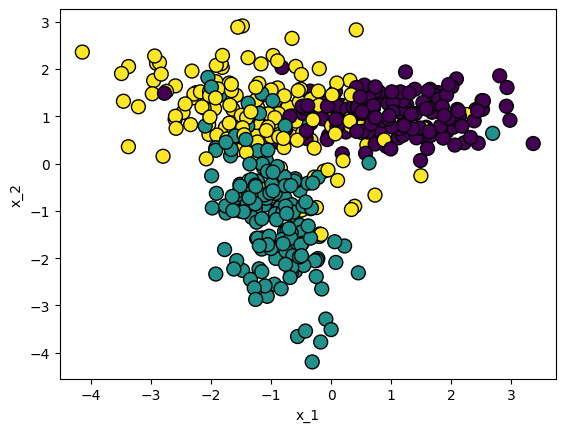

In [43]:
X, y = make_classification(n_samples=500,
                           n_features=2,
                           n_classes=3,
                           n_clusters_per_class=1,
                           n_informative=2,
                           n_redundant=0,
                           random_state=40)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100, edgecolor="k", linewidth=1)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.show()

### SVM 모델 구현

In [44]:
class SVM:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None  # 가중치 벡터
        self.bias = None  # 절편

    def fit(self, X, y,find):
        """
        SVM 모델 학습
        - X: 입력 데이터 (data 개수 x feature 개수)
        - y: 타겟 레이블 (data 개수만큼 -1 또는 1로 이루어진 배열)
        """
        n_samples, n_features = X.shape # n_samples: 데이터 개수

        # 레이블을 -1 또는 1로 변환
        y_modified = np.where(y == find, -1, 1)

        # Weight 및 bias 초기화
        self.weights = np.zeros(n_features)  # 가중치 벡터
        self.bias = 0  # 절편

        # Gradient Decent
        for _ in range(self.n_iters):
          for idx in range(n_samples):
            X_i = X[idx]
            y_i = y_modified[idx]

            condition = y_i * (np.dot(self.weights.T,X_i)+self.bias) >= +1

            if condition:
              pass
            else:
              self.weights = self.weights - self.learning_rate *(-np.dot(y_i,X_i))
              self.bias = self.bias - self.learning_rate *(-y_i)


    def predict(self, X):
        """
        새로운 데이터에 대한 클래스 예측
        - X: 입력 데이터
        - 반환값: 예측된 클래스 레이블 (-1 또는 1)
        """
        # 결정 함수: w^T * x + b
        linear_output = np.dot(X, self.weights) + self.bias
        # sign 함수로 -1 또는 1로 변환
        return np.sign(linear_output)

### Prediction

[-1.49414232 -0.55470441] 0.4270000000000003


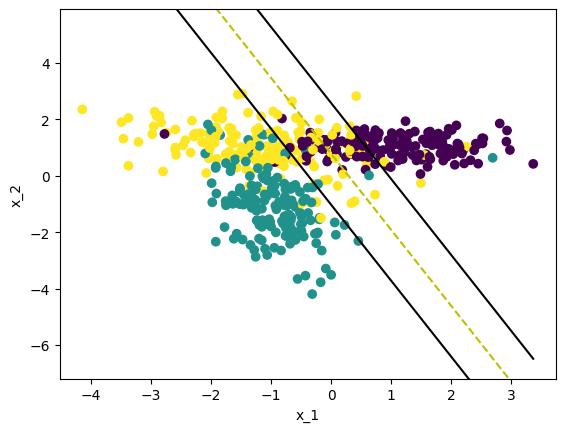

[0.40125975 1.58108005] 0.34500000000000025


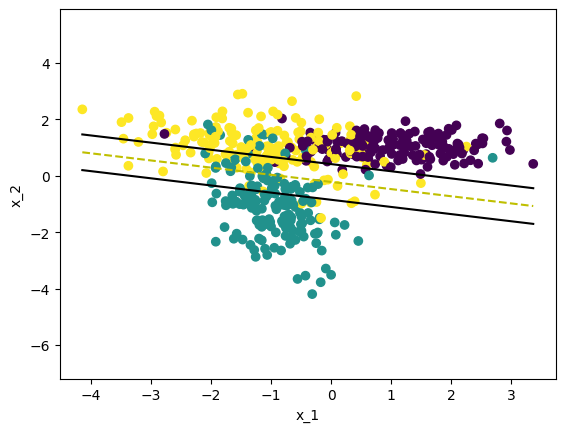

[ 0.83715128 -0.90755043] 1.532999999999942


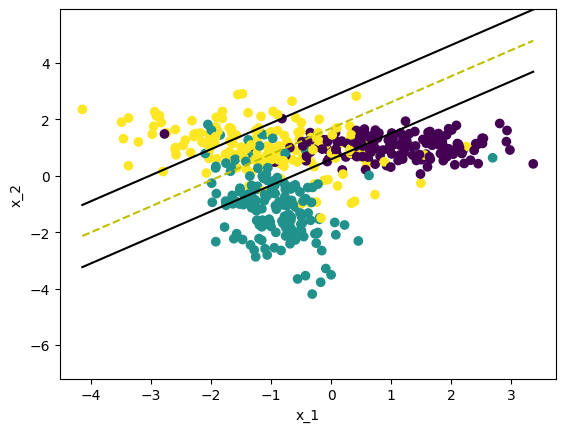

In [46]:
# model 1
def get_hyperplane_value(x, w, b, offset):
    return (-w[0] * x - b + offset) / w[1]

def visualize_svm(w, b):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.show()
model = SVM()
margin_log = model.fit(X, y,0)

print(model.weights, model.bias)
visualize_svm(model.weights, model.bias)
# model 2
model = SVM()
margin_log = model.fit(X, y,1)

print(model.weights, model.bias)
visualize_svm(model.weights, model.bias)

# model 3
model = SVM()
margin_log = model.fit(X, y,2)

print(model.weights, model.bias)
visualize_svm(model.weights, model.bias)







## -----------------------------------------------------------------

## 기말고사 연습문제 3

### 패키지 선언

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Dataset 선언

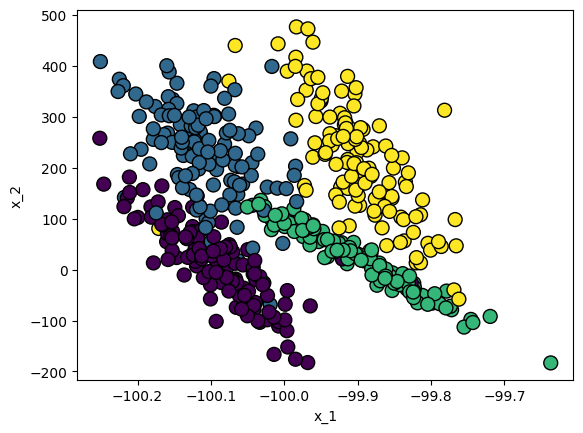

Training samples:  400
Testing samples:  100


In [48]:
X, y = make_classification(n_samples=500,
                           n_features=2,
                           n_classes=4,
                           n_clusters_per_class=1,
                           n_informative=2,
                           n_redundant=0,
                           random_state=40)

X[:, 0] = X[:, 0] * 0.1 - 100
X[:, 1] = X[:, 1] * 100 + 120

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100, edgecolor="k", linewidth=1)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.show()

# Training/Testing Dataset 분리 (80:20)


print("Training samples: ", len(X_train))
print("Testing samples: ", len(X_test))

### 정규화 수행

In [67]:
#def gaussian_normalization(X):
#     mean = np.mean(X, axis=0)  # 각 특성의 평균
#     std = np.std(X, axis=0)    # 각 특성의 표준편차
#     normalized_X = (X - mean) / std  # 정규화
#     return normalized_X
#X = gaussian_normalization(X)

scaler = StandardScaler()
X= scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

### KNN 모델 구현

In [68]:
def L2_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
  def __init__(self, k=3):
    # initialization
    self.k = k
    self.train_data = None
    self.train_label = None

  def fit(self, X, y):
    # Storage training datas
    self.train_data = X
    self.train_label = y
  def predict(self, X):
    # Prediction
    answer = []
    for test_data in X:
      distance=[]
      for train_data in self.train_data:
        distance.append(L2_distance(test_data,train_data))
      test_label = np.argsort(distance)[:self.k]
      label_count = []
      for label in test_label:
        label_count.append(self.train_label[label])
      answer.append(max(label_count,key = label_count.count))
    return answer

### Prediction

In [69]:
model = KNN()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = np.sum(y_pred == y_test) / len(y_test)
print(accuracy)

0.94


## -----------------------------------------------------------------

## 기말고사 연습문제 4

### 패키지 선언

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

### Dataset 선언

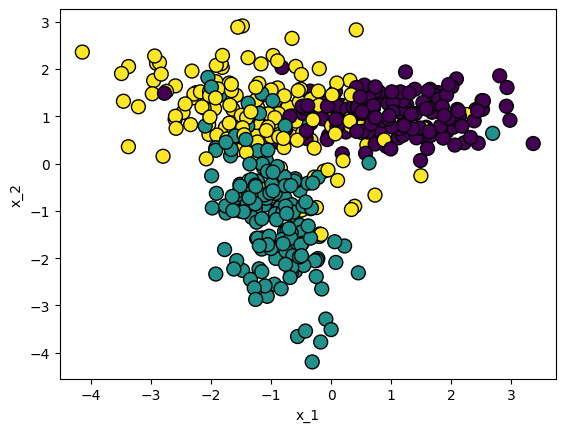

Training samples:  400
Testing samples:  100


In [75]:
X, y = make_classification(n_samples=500,
                           n_features=2,
                           n_classes=3,
                           n_clusters_per_class=1,
                           n_informative=2,
                           n_redundant=0,
                           random_state=40)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100, edgecolor="k", linewidth=1)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.show()
def gaussian_normalization(X):
    mean = np.mean(X, axis=0)  # 각 특성의 평균
    std = np.std(X, axis=0)    # 각 특성의 표준편차
    normalized_X = (X - mean) / std  # 정규화
    return normalized_X
X = gaussian_normalization(X)
# Training/Testing Dataset 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print("Training samples: ", len(X_train))
print("Testing samples: ", len(X_test))

### Training dataset 분리

In [76]:
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

### KNN 모델 구현

In [77]:
def L2_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
  def __init__(self):
    self.k = None
    self.train_data = None
    self.train_label = None


  def fit(self, X, y):
    # Storage training datas
    self.train_data = X
    self.train_label = y

  def predict(self, X, k):
    self.k=k
    answer = []
    for test_data in X:
      distance=[]
      for train_data in self.train_data:
        distance.append(L2_distance(test_data,train_data))
      test_label = np.argsort(distance)[:self.k]
      label_count = []
      for label in test_label:
        label_count.append(self.train_label[label])
      answer.append(max(label_count,key = label_count.count))
    return answer
    # Prediction

### Prediction

In [78]:
model = KNN()
model.fit(X_train_temp, y_train_temp)
k_list = list(range(1, 10))

answer = []
for k in k_list:
  y_pred = model.predict(X_test_temp, k)
  accuracy = np.sum(y_pred == y_test_temp) / len(y_test_temp)
  answer.append(accuracy)
  print(k,accuracy)
print(np.argmax(answer)+1)

1 0.8
2 0.8
3 0.8125
4 0.8375
5 0.875
6 0.8625
7 0.8375
8 0.8375
9 0.85
5
